# Linear Regression

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Leer la data

In [36]:
df = pd.read_csv('processed_data_listings.csv')
# Se ajusta el rango del precio entre 0 y 500.
df= df[(df['price'] > 0) & (df['price'] < 500)]
# Se eliminan columnas numericas sin relevancia
df = df.drop(columns = ['id'])
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Tower Hamlets,51.52874,-0.05396,Private room,55,3,1,74,0
1,Islington,51.56861,-0.11270,Private room,50,1,2,343,9
2,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,1,222,1
3,Islington,51.52478,-0.10484,Private room,180,4,5,236,20
4,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,1,180,2


## Onehot encoding

In [38]:
df_hot_encoding = pd.get_dummies(df, columns=['neighbourhood', 'room_type'], drop_first=True)

## Transformacion logaritmica

Se utiliza para reducir la escala de valores y para manejar datos con sesgo o asimetría. Al aplicar la función logarítmica a los datos, se reduce la diferencia entre valores más grandes y más pequeños, lo que puede ayudar a estabilizar la varianza y mejorar la interpretación de las relaciones entre las variables

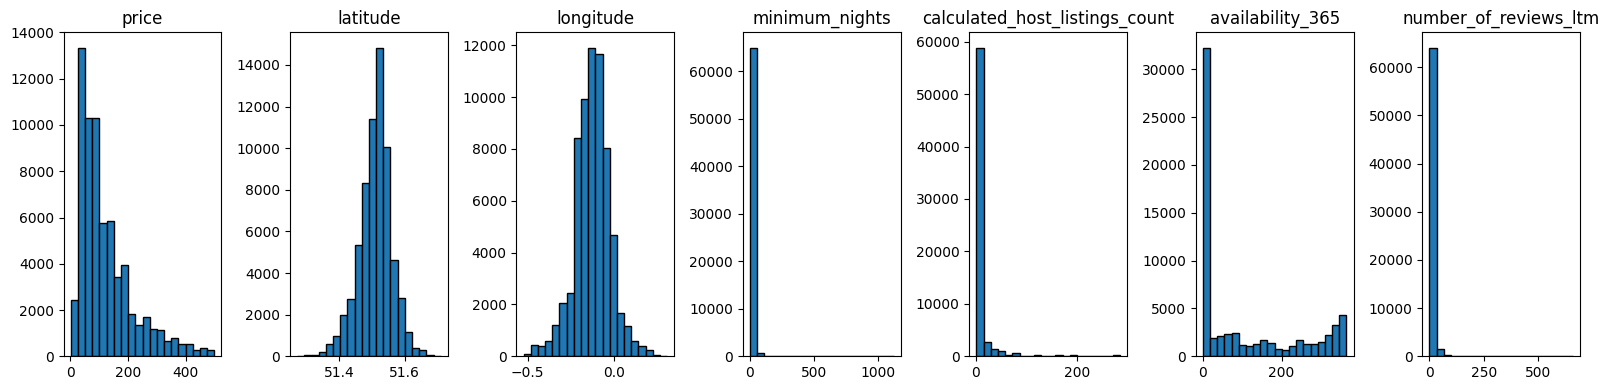

In [39]:
numeric_col = ['price', 'latitude', 'longitude','minimum_nights', 'calculated_host_listings_count','availability_365', 'number_of_reviews_ltm'] #, 'number_of_reviews_ltm'

# Crear una sola fila de subgráficos
fig, axes = plt.subplots(1, len(numeric_col), figsize=(16, 4))
# Generar histogramas para cada columna numérica
for i, col in enumerate(numeric_col):
    axes[i].hist(df_hot_encoding[col], bins=20, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

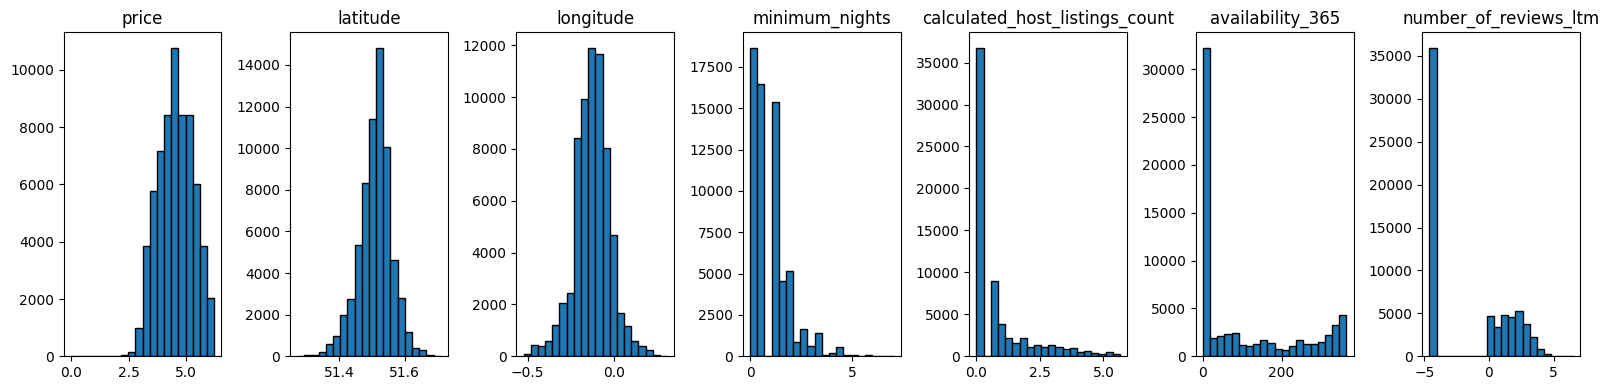

In [40]:
# Log transforming columns
numerical_columns = [i for i in numeric_col
                     if i not in ['availability_365', 'latitude', 'longitude']] # Removing items not to be transformed

for col in numerical_columns:
    df_hot_encoding[col] = df_hot_encoding[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_hot_encoding[col] = np.log(df_hot_encoding[col])

# Crear una sola fila de subgráficos
fig, axes = plt.subplots(1, len(numeric_col), figsize=(16, 4))
# Generar histogramas para cada columna numérica
for i, col in enumerate(numeric_col):
    axes[i].hist(df_hot_encoding[col], bins=20, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

## Preparar la data para el modelo

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_hot_encoding.drop('price', axis=1)
y = df_hot_encoding.price
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size=0.2, random_state = 123)

print("Training set: Xt:{} Yt:{}".format(train_X.shape, train_y.shape))
print("Validation set: Xv:{} Yv:{}".format(validation_X.shape, validation_y.shape))
print("-")
print("Full dataset: X:{} Y:{}".format(X.shape, y.shape))

Training set: Xt:(52724, 41) Yt:(52724,)
Validation set: Xv:(13181, 41) Yv:(13181,)
-
Full dataset: X:(65905, 41) Y:(65905,)


## Modelo

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score, mean_squared_error

In [54]:
linear_model = LinearRegression()

linear_model.fit(train_X, train_y)

LinearRegression()

In [55]:
x_pred = linear_model.predict(train_X)
y_pred = linear_model.predict(validation_X)

In [56]:
# Metricas de evaluacion para el train
mae_x = mean_absolute_error(train_y, x_pred) # MAE (Mean Absolute Error)
r2_x = r2_score(train_y, x_pred) # R^2
rmse_x = np.sqrt(mean_squared_error(train_y, x_pred)) # RMSE (Root Mean Squared Error)

print(f'MAE: {mae_x:.4f}')
print(f'R^2: {r2_x:.4f}')
print(f'RMSE: {rmse_x:.4f}')

MAE: 0.3895
R^2: 0.5595
RMSE: 0.4940


In [57]:
# Metricas de evaluacion para el test
mae_y = mean_absolute_error(validation_y, y_pred) # MAE (Mean Absolute Error)
r2_y = r2_score(validation_y, y_pred) # R^2
rmse_y = np.sqrt(mean_squared_error(validation_y, y_pred)) # RMSE (Root Mean Squared Error)

print(f'MAE: {mae_y:.4f}')
print(f'R^2: {r2_y:.4f}')
print(f'RMSE: {rmse_y:.4f}')

MAE: 0.3906
R^2: 0.5615
RMSE: 0.4949


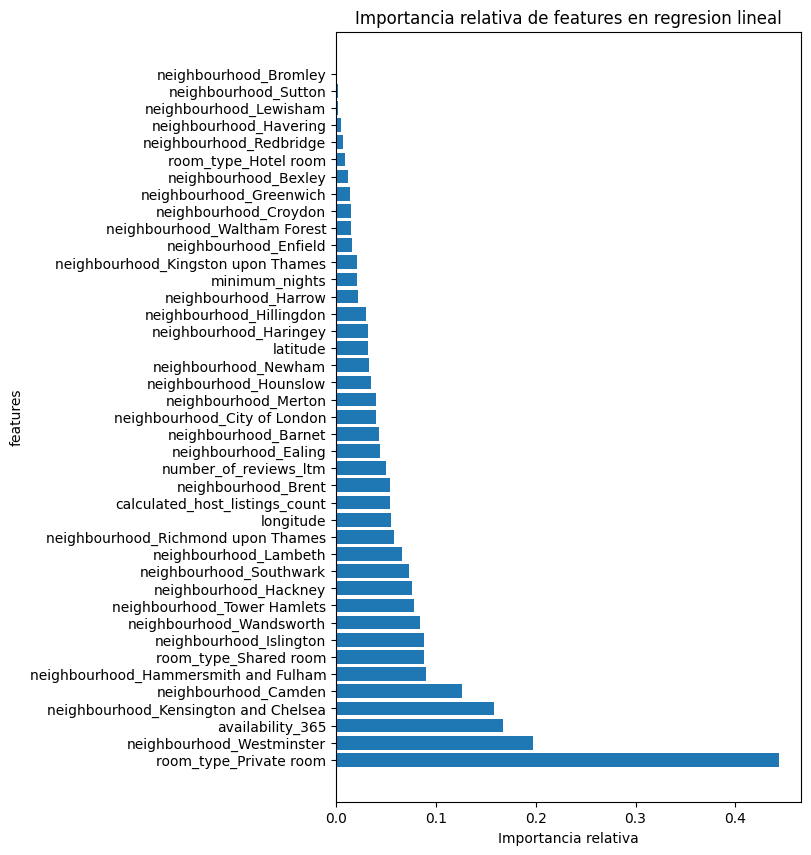

In [85]:
# Obtener los coeficientes del modelo
coefficients = linear_model.coef_
feature_importance = np.abs(coefficients)

# Crear una lista de nombres de características
feature_names = train_X.columns.tolist()

# Obtener los índices que ordenan la importancia de mayor a menor
indices_sorted = np.argsort(feature_importance)[::-1]

# Ordenar las características y la importancia relativa según los índices ordenados
sorted_feature_names = [feature_names[i] for i in indices_sorted]
sorted_feature_importance = feature_importance[indices_sorted]

# Visualizar la importancia relativa de las características en un gráfico de barras ordenado
plt.figure(figsize=(6, 10))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Importancia relativa')
plt.ylabel('features')
plt.title('Importancia relativa de features en regresion lineal')
plt.show()

In [59]:
validation_y_array = np.array(list(validation_y))
val_preds_hpm_reg_array = np.array(y_pred)
df_comparison_predictions = pd.DataFrame({'Actual': validation_y_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
df_comparison_predictions

,Actual,Predicted
0,4.700480,4.789376
1,3.401197,3.628619
2,5.105945,4.089849
3,5.293305,3.869277
4,4.219508,4.634910
...,...,...
13176,3.663562,4.197772
13177,4.007333,4.741755
13178,4.859812,4.677407
13179,4.477337,4.766922


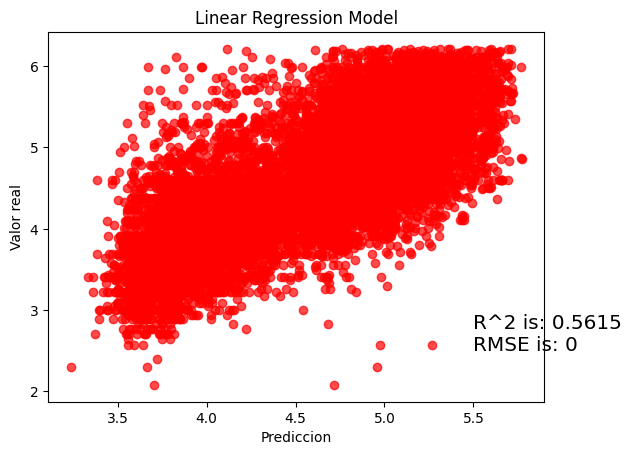

In [61]:
actual_values = validation_y
plt.scatter(y_pred, actual_values, alpha=.7, color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(validation_y, y_pred),4)),
                    (round(mean_squared_error(validation_y, y_pred))),4)
plt.annotate(text=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Linear Regression Model')
plt.show()

Podemos intentar usar Ridge Regularization para disminuir la influencia de características menos importantes. Ridge Regularization es un proceso que reduce los coeficientes de regresión de características menos importantes.

Una vez más instanciaremos el modelo. El modelo de regularización de Ridge toma un parámetro, alfa, que controla la fuerza de la regularización.

In [73]:
from sklearn.linear_model import Ridge
import numpy as np

# Crear instancia del modelo de regresión Ridge
ridge_model = Ridge(alpha=0.0)  # Se itera sobre este valor para probar diferentes resultados

# Entrenar el modelo de regresión Ridge con los datos de entrenamiento
ridge_model.fit(train_X, train_y)

# Obtener los coeficientes del modelo
coefficients = ridge_model.coef_

# Establecer un umbral para eliminar características menos importantes
threshold = 0.05  # Se itera sobre este valor para probar diferentes resultadoss

# Identificar las características con coeficientes inferiores al umbral
less_important_features = np.where(np.abs(coefficients) < threshold)[0]

# Establecer los coeficientes de las características menos importantes a cero
coefficients[less_important_features] = 0

# Actualizar el modelo con los coeficientes modificados
ridge_model.coef_ = coefficients

# Realizar predicciones en el conjunto de entrenamiento y validación con el nuevo modelo
x_pred_ridge = ridge_model.predict(train_X)
y_pred_ridge = ridge_model.predict(validation_X)

In [74]:
# Calcular R^2 en el conjunto de entrenamiento y validación
r2_train = r2_score(train_y, x_pred_ridge)
r2_validation = r2_score(validation_y, y_pred_ridge)

# Calcular MSE en el conjunto de entrenamiento y validación
mse_train = mean_squared_error(train_y, x_pred_ridge)
mse_validation = mean_squared_error(validation_y, y_pred_ridge)

# Calcular MAE en el conjunto de entrenamiento y validación
mae_train = mean_absolute_error(train_y, x_pred_ridge)
mae_validation = mean_absolute_error(validation_y, y_pred_ridge)

print("Resultados en el conjunto de entrenamiento:")
print("R^2:", r2_train)
print("MSE:", mse_train)
print("MAE:", mae_train)

print("\nResultados en el conjunto de validación:")
print("R^2:", r2_validation)
print("MSE:", mse_validation)
print("MAE:", mae_validation)

Resultados en el conjunto de entrenamiento:
R^2: 0.5386732028839887
MSE: 0.2555479254794938
MAE: 0.3981887522837917

Resultados en el conjunto de validación:
R^2: 0.5409729950564203
MSE: 0.25640416640183
MAE: 0.39912928395465364


El modelo no mejora, esto puede deberse a que no tenemos muchas features y cuando le borramos los que menos importancia tienen disminuye un poco el performance.